In [1]:
# pip install torch numpy matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import random

# set random seed
fix_seed = 2025
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

from Autoregressive import Model as ARAttn
from AutoregressiveAlignment import Model as ARForecast

In [2]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
from dataset import VARNDataset

class ARMAConfig:
    seq_len = 64                 # L_I, length of input
    pred_len = 1                 # L_P, forecasting horizon
    
    label_len = seq_len           # placeholder for predictors with encoder-decoder structure
    enc_in = 2                    # C, number of input series
    number_of_targets = 2
    d_model = 32
    dropout = 0.1
    e_layers = 3
    n_heads = 2
    predictor = 'LinearAttention'
    time_emb_dim = 0              # no timestamp embedding by default
    features = 'M'

    local_attention = False
    local_attention_window = 8

ar_config = ARMAConfig()

dataset_train = VARNDataset(C=ar_config.enc_in, L_I=ar_config.seq_len, L_P=ar_config.pred_len, ds_type='train')
dataset_val = VARNDataset(C=ar_config.enc_in, L_I=ar_config.seq_len, L_P=ar_config.pred_len, ds_type='val')

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True, pin_memory=True, drop_last=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=256, shuffle=True, pin_memory=True, drop_last=False)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [3]:
# LinTrans
def model_forward_arattn(model, d):
    x_i, x_p = d
    x_i = x_i.to(device, non_blocking=True)
    x_i = x_i[:, -(ar_config.local_attention_window*ar_config.pred_len):, :]
    x_p = x_p.to(device, non_blocking=True)
    
    if model.training:
        random_drop_rate = torch.rand(1).item()
        drop_mask = torch.rand(1, 1, x_i.shape[2], device=x_i.device) < 1-random_drop_rate
        x_i = x_i.masked_fill(drop_mask, 0)
        x_p = x_p.masked_fill(drop_mask, 0)
        output, loss = model(x_i)
    else:
        output = model(x_i)
        loss = 0
    mse_loss = F.mse_loss(output, x_p)
    total_loss = mse_loss + loss
    return output, total_loss

# SAMoVAR
def model_forward_arforecast(model, d):
    x_i, x_p = d
    x_i = x_i.to(device, non_blocking=True)
    x_p = x_p.to(device, non_blocking=True)

    if model.training:
        random_drop_rate = torch.rand(1).item()
        drop_mask = torch.rand(1, 1, x_i.shape[2], device=x_i.device) < 1-random_drop_rate
        x_i = x_i.masked_fill(drop_mask, 0)
        x_p = x_p.masked_fill(drop_mask, 0)
        output, loss = model(x_i)
    else:
        output = model(x_i)
        loss = 0
    mse_loss = F.mse_loss(output, x_p)
    total_loss = mse_loss + loss
    return output, total_loss

# FixedVAR
def model_forward_fixedvar(model, d):
    x_i, x_p = d
    x_i = x_i.to(device, non_blocking=True)
    x_p = x_p.to(device, non_blocking=True)

    if model.training:
        random_drop_rate = torch.rand(1).item()
        drop_mask = torch.rand(1, 1, x_i.shape[2], device=x_i.device) < 1-random_drop_rate
        x_i = x_i.masked_fill(drop_mask, 0)
        x_p = x_p.masked_fill(drop_mask, 0)
        output, _ = model(x_i)
        loss = 0
    else:
        output = model(x_i)
        loss = 0
    mse_loss = F.mse_loss(output, x_p)
    total_loss = mse_loss + loss
    return output, total_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model_arattn = ARAttn(ar_config).to(device)
model_arforecast = ARForecast(ar_config).to(device)

fixed_var_config = copy.deepcopy(ar_config)
fixed_var_config.n_layer = 1
fixed_var_config.n_heads = 1
fixed_var_config.predictor = 'FixedVAR'
model_fixedvar = ARForecast(fixed_var_config).to(device)

if torch.cuda.is_available() and torch.__version__ > '2.0':
    model_arattn = torch.compile(model_arattn)
    model_arforecast = torch.compile(model_arforecast)
    model_fixedvar = torch.compile(model_fixedvar)
    
runs = {
    'ARAttn': {'model': model_arattn, 'forward': model_forward_arattn, 'train_losses': [],  'test_losses': [], 'initial_lr': 0.0006},
    'SAMoVAR': {'model': model_arforecast, 'forward': model_forward_arforecast, 'train_losses': [],  'test_losses': [], 'initial_lr': 0.0006},
    'FixedVAR': {'model': model_fixedvar, 'forward': model_forward_fixedvar, 'train_losses': [],  'test_losses': [], 'initial_lr': 0.0006}
}

Using device: cuda


In [4]:
import time

for model_name in runs:

    initial_lr = runs[model_name]['initial_lr']
    num_epochs = 100
    warmup_epochs = num_epochs // 10 if num_epochs > 10 else 1

    optimizer = torch.optim.AdamW(runs[model_name]['model'].parameters(), lr=initial_lr, betas=(0.9, 0.95), weight_decay=0.1)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, 
        lr_lambda=lambda epoch: epoch / warmup_epochs if epoch <= warmup_epochs else (1 - (epoch - warmup_epochs) / (num_epochs - warmup_epochs))
    )

    runs[model_name]['model'].train()
    epoch_losses = []
    validation_losses = []

    num_batches = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0


        # Training loop
        for d in dataloader_train:
            optimizer.zero_grad()
            output, loss = runs[model_name]['forward'](runs[model_name]['model'], d)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            if num_batches % 50 == 0:
                elapsed_time = time.time() - start_time
                print(f'Epoch {epoch+1}, Step {num_batches}, Average Loss: {total_loss / num_batches:.4f}, Elapsed Time: {elapsed_time:.2f} sec')

        scheduler.step()

        average_loss = total_loss / num_batches
        epoch_losses.append(average_loss)
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1},          Average Loss: {average_loss:.4f}, Total Elapsed Time: {elapsed_time:.2f} sec")

        # Validation loop
        runs[model_name]['model'].eval()
        val_total_loss = 0
        val_num_batches = 0

        with torch.no_grad():
            for d in dataloader_val:
                output, loss = runs[model_name]['forward'](runs[model_name]['model'], d)
                val_total_loss += loss.item()
                val_num_batches += 1

        val_average_loss = val_total_loss / val_num_batches
        validation_losses.append(val_average_loss)
        print(f"{model_name} - Epoch {epoch+1}, Validation Loss: {val_average_loss:.4f}")

        runs[model_name]['model'].train()

    runs[model_name]['train_losses'] = copy.deepcopy(epoch_losses)
    runs[model_name]['test_losses'] = copy.deepcopy(validation_losses)

Epoch 1, Step 50, Average Loss: 2.4687, Elapsed Time: 5.24 sec
Epoch 1,          Average Loss: 2.4827, Total Elapsed Time: 11.82 sec
ARAttn - Epoch 1, Validation Loss: 0.0769
Epoch 2, Step 100, Average Loss: 0.5021, Elapsed Time: 0.22 sec
Epoch 2, Step 150, Average Loss: 1.1807, Elapsed Time: 0.63 sec
Epoch 2,          Average Loss: 1.2310, Total Elapsed Time: 0.70 sec
ARAttn - Epoch 2, Validation Loss: 0.0739
Epoch 3, Step 200, Average Loss: 0.3831, Elapsed Time: 0.47 sec
Epoch 3,          Average Loss: 0.6608, Total Elapsed Time: 0.81 sec
ARAttn - Epoch 3, Validation Loss: 0.0664
Epoch 4, Step 250, Average Loss: 0.0900, Elapsed Time: 0.11 sec
Epoch 4, Step 300, Average Loss: 0.4778, Elapsed Time: 0.54 sec
Epoch 4,          Average Loss: 0.5502, Total Elapsed Time: 0.70 sec
ARAttn - Epoch 4, Validation Loss: 0.0377
Epoch 5, Step 350, Average Loss: 0.1874, Elapsed Time: 0.34 sec
Epoch 5,          Average Loss: 0.3081, Total Elapsed Time: 0.71 sec
ARAttn - Epoch 5, Validation Loss: 0.02

/root/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


Epoch 1, Step 50, Average Loss: 2.2658, Elapsed Time: 12.79 sec


/root/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


Epoch 1,          Average Loss: 2.2842, Total Elapsed Time: 29.66 sec


/root/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


SAMoVAR - Epoch 1, Validation Loss: 0.0899
Epoch 2, Step 100, Average Loss: 0.6057, Elapsed Time: 0.28 sec
Epoch 2, Step 150, Average Loss: 1.3230, Elapsed Time: 0.92 sec
Epoch 2,          Average Loss: 1.4264, Total Elapsed Time: 1.02 sec
SAMoVAR - Epoch 2, Validation Loss: 0.0754
Epoch 3, Step 200, Average Loss: 0.4212, Elapsed Time: 0.54 sec
Epoch 3,          Average Loss: 0.6744, Total Elapsed Time: 1.02 sec
SAMoVAR - Epoch 3, Validation Loss: 0.0899
Epoch 4, Step 250, Average Loss: 0.1317, Elapsed Time: 0.17 sec
Epoch 4, Step 300, Average Loss: 0.4940, Elapsed Time: 0.85 sec
Epoch 4,          Average Loss: 0.5815, Total Elapsed Time: 1.05 sec
SAMoVAR - Epoch 4, Validation Loss: 0.0631
Epoch 5, Step 350, Average Loss: 0.1528, Elapsed Time: 0.47 sec
Epoch 5,          Average Loss: 0.2709, Total Elapsed Time: 1.08 sec
SAMoVAR - Epoch 5, Validation Loss: 0.0707
Epoch 6, Step 400, Average Loss: 0.0267, Elapsed Time: 0.07 sec
Epoch 6, Step 450, Average Loss: 0.1698, Elapsed Time: 0.74 s

/root/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


Epoch 1, Step 50, Average Loss: 1.4369, Elapsed Time: 14.75 sec
Epoch 1,          Average Loss: 1.5813, Total Elapsed Time: 15.09 sec


/root/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


FixedVAR - Epoch 1, Validation Loss: 0.0736
Epoch 2, Step 100, Average Loss: 0.4434, Elapsed Time: 0.27 sec
Epoch 2, Step 150, Average Loss: 1.0145, Elapsed Time: 0.88 sec
Epoch 2,          Average Loss: 1.0920, Total Elapsed Time: 0.98 sec
FixedVAR - Epoch 2, Validation Loss: 0.0740
Epoch 3, Step 200, Average Loss: 0.5283, Elapsed Time: 0.51 sec
Epoch 3,          Average Loss: 0.6286, Total Elapsed Time: 0.98 sec
FixedVAR - Epoch 3, Validation Loss: 0.0706
Epoch 4, Step 250, Average Loss: 0.1259, Elapsed Time: 0.16 sec
Epoch 4, Step 300, Average Loss: 0.3803, Elapsed Time: 0.77 sec
Epoch 4,          Average Loss: 0.4085, Total Elapsed Time: 0.97 sec
FixedVAR - Epoch 4, Validation Loss: 0.0610
Epoch 5, Step 350, Average Loss: 0.1179, Elapsed Time: 0.42 sec
Epoch 5,          Average Loss: 0.2105, Total Elapsed Time: 0.96 sec
FixedVAR - Epoch 5, Validation Loss: 0.0753
Epoch 6, Step 400, Average Loss: 0.0152, Elapsed Time: 0.06 sec
Epoch 6, Step 450, Average Loss: 0.1145, Elapsed Time: 0

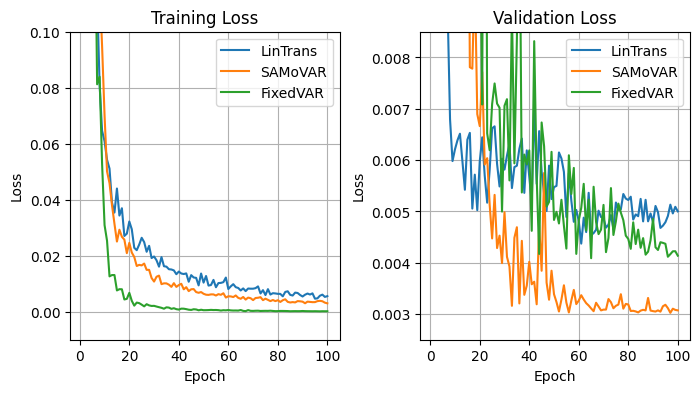

In [5]:
plt.figure(figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 2, 1) 
for model_name in runs:
    if model_name == 'ARAttn':
        vis_name = 'LinTrans'
    else:
        vis_name = model_name
    plt.plot(range(1, num_epochs + 1), runs[model_name]['train_losses'], label=f'{vis_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(-0.01, 0.1)
plt.legend()
plt.grid(True)
plt.title('Training Loss')

plt.subplot(1, 2, 2)
for model_name in runs:
    if model_name == 'ARAttn':
        vis_name = 'LinTrans'
    else:
        vis_name = model_name
    plt.plot(range(1, num_epochs + 1), runs[model_name]['test_losses'], label=f'{vis_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0025, 0.0085)
plt.legend()
plt.grid(True)
plt.title('Validation Loss')

plt.savefig("train_val_loss_combined.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [6]:
def mts_visualize(pred, true, split_step=720, title='TSF', dpi=72, col_names=None):
    groups = range(true.shape[-1])
    C = true.shape[-1]
    i = 1
    # plot each column
    f = plt.figure(figsize=(10, 2.1*len(groups)), dpi=dpi)
    f.suptitle(title, y=0.9)
    index = 0
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(true[:, group], alpha=0.75, label='True', marker='.')
        if type(pred) is list:
            for index, p in enumerate(pred):
                plt.plot(list(range(split_step, true.shape[0])), p[:, group], alpha=0.5, label=f'Pred_{index}', marker='o')
        else:
            plt.plot(list(range(split_step, true.shape[0])), pred[:, group], alpha=0.75, label='Pred', marker='o')
        #plt.title(f'S{i}', y=1, loc='right')
        if col_names is None or C-index > len(col_names):
            plt.title(f"Series (-{C-index})", y=1, loc='right')
        else:
            plt.title(f"{col_names[-(C-index)]} (-{C-index})", y=1, loc='right')
        index += 1
        plt.legend(loc='lower left')
        plt.axvline(x=split_step, linewidth=1, color='Purple')
        i += 1
    return f

In [7]:
import seaborn as sns
from tqdm.auto import tqdm

def visualize_optimized_var(weights, observations, height_ratio=1):
    L, C, dim = weights.shape

    fig, axes = plt.subplots(dim, 1, figsize=(12, height_ratio * dim), sharex=True)
    if dim == 1: 
        axes = [axes]

    for i in tqdm(range(dim)):
        cumulative_weights = weights[:, :, i].T 
        time = np.arange(1, L + 1)
        im = axes[i].imshow(
            cumulative_weights, 
            aspect="auto", 
            cmap="coolwarm", 
            extent=[1, L, C - 0.5, -0.5]
        )
        axes[i].set_title(f"Variable {i} - Cumulative Lag Weights & Observations")
        axes[i].set_ylabel("Contributing Variable")
        axes[i].set_yticks(range(C))
        axes[i].set_yticklabels([f"Var {j}" for j in range(C)])

        cbar = plt.colorbar(im, ax=axes[i], fraction=0.02, pad=0.04)
        cbar.set_label("Weight Magnitude")

        for j in range(C):
            current_observations = observations[:, j]
            current_observations = (current_observations - current_observations.min()) / (current_observations.max() - current_observations.min())
            current_observations = current_observations - 0.5
            axes[i].plot(
                time, 
                current_observations+j, 
                #marker="o", 
                #color="grey", 
                label=f"Observation - Var {i}", 
                linewidth=1.5,
                alpha = 0.75
            )
        axes[i].legend()

    axes[-1].set_xlabel("Lag Time")
    plt.tight_layout()
    plt.show()


dl = dataloader_val
    
dl.dataset.get_index = True
flag = False
for d in dl:
    var_weight = dl.dataset.get_var_weights(d[2][0])

model_arforecast = runs['SAMoVAR']['model']

model_arforecast.eval()
x_input = d[0][[0]].to(device)

layer_index = None
factor_index = 0
head_index = None

q, k, v = model_arforecast.collect_qkv(x_input)

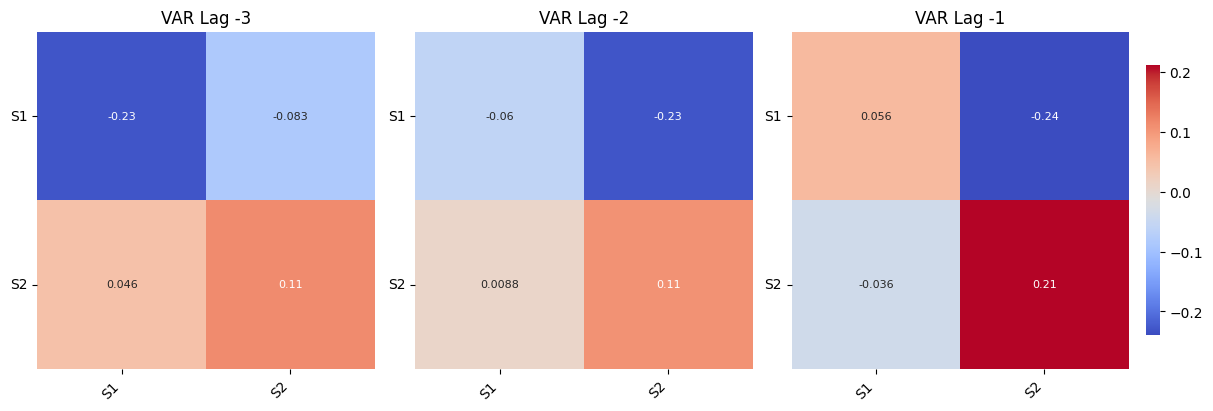

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

weights = np.array(var_weight[::-1])
# Determine L (lag number) and d (dimension)
L, dim, _ = weights.shape

# Setup the figure with tight layout
fig, axes = plt.subplots(1, L, figsize=(4 * L, 4), constrained_layout=True)

# Heatmap settings
cmap = 'coolwarm'
vmin, vmax = np.min(weights), np.max(weights)  # Dynamic color scaling

# Plot each heatmap
for i, ax in enumerate(axes):
    sns.heatmap(weights[i], ax=ax, annot=True, cmap=cmap, vmin=vmin, vmax=vmax, 
                cbar=i == L-1, cbar_kws={'shrink': 0.8}, square=True, annot_kws={"size": 8})
    ax.set_title(f'VAR Lag -{L-i}', fontsize=12)
    ax.set_xticklabels([f'S{j+1}' for j in range(dim)], rotation=45, ha='right')
    ax.set_yticklabels([f'S{j+1}' for j in range(dim)], rotation=0)

plt.savefig(f"var_weight_heatmap.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

/tmp/ipykernel_34830/3252279429.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_paths))


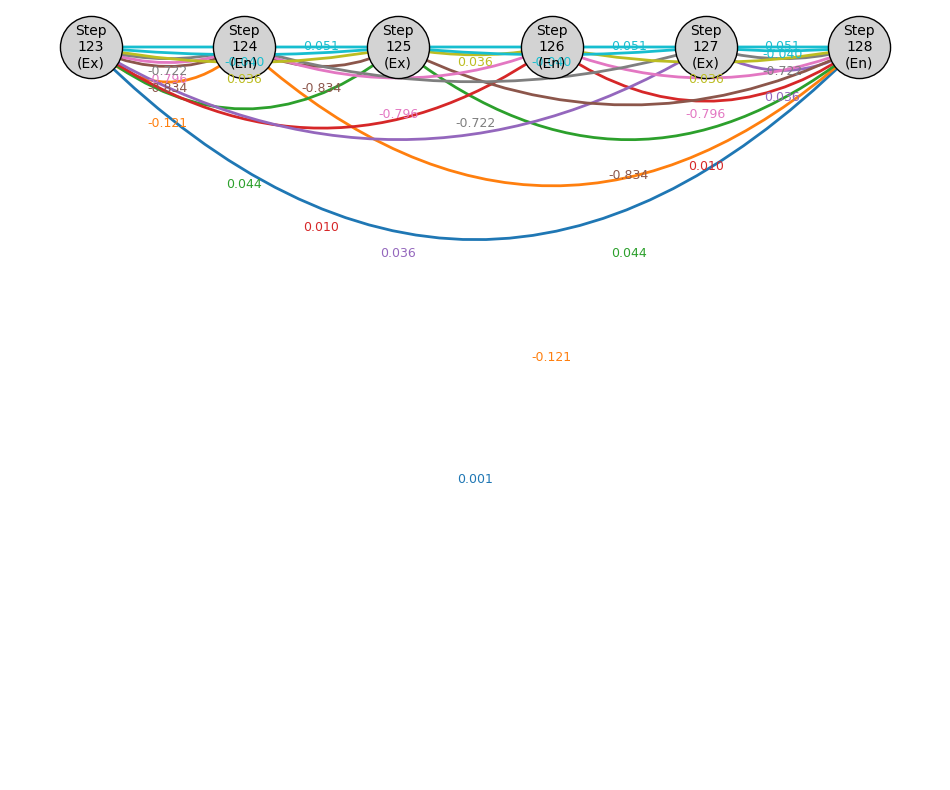

In [9]:
%matplotlib inline
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def visualize_path(Q, K, V, j, t, factor_index=0, head_index=0):
    relative_j = 0
    relative_t = t - j
    M, B, L, h, d = Q.shape
    j_orig = int(j)
    
    Q = Q[::-1]
    #K = K[::-1]
    V = V[::-1]

    path_weights = {}
    for l in range(1, M+1): 
        for intermediate_points in itertools.combinations(range(j + 1, t), l - 1):
            path = (relative_j, *[point - j for point in intermediate_points], relative_t)

            current_product = 1.0 / d
            if head_index is not None:
                first_v = V[0, 0, path[1], head_index, :]
                last_q = Q[M - 1, 0, path[-1], head_index, :]
                #current_product *= np.dot(last_q, first_v)
            else:
                first_v = V[0, 0, path[1], :, :]
                last_q = Q[M - 1, 0, path[-1], :, :]
            current_product *= np.sum(first_v * last_q, axis=-1)

            for idx in range(1, len(path) - 1):
                v_index = path[idx]
                q_index = path[idx - 1]
                if head_index is not None:
                    v_vector = V[idx, factor_index, v_index, head_index, :]
                    q_vector = Q[idx - 1, factor_index, q_index, head_index, :]
                    #current_product *= np.dot(q_vector, v_vector)
                else:
                    v_vector = V[idx, factor_index, v_index, :, :]
                    q_vector = Q[idx - 1, factor_index, q_index, :, :]
                current_product *= np.sum(q_vector * v_vector, axis=-1)

            path_weights[path] = current_product.mean()

    plt.figure(figsize=(12, 10))
    G = nx.DiGraph()
    pos = {node: (i, 0) for i, node in enumerate(sorted(set([n for path in path_weights for n in path])))}
    unique_paths = list(path_weights.keys())
    cmap = plt.cm.get_cmap('tab10', len(unique_paths))
    path_colors = {unique_paths[i]: cmap(i) for i in range(len(unique_paths))}
    max_path = max(unique_paths, key=len)
    G.add_nodes_from(pos.keys())

    for path in unique_paths:
        edges = [(path[j], path[j + 1]) for j in range(len(path) - 1)]
        G.add_edges_from(edges)

    ax = plt.gca()
    for i, path in enumerate(unique_paths):
        edges = [(path[j], path[j + 1]) for j in range(len(path) - 1)]
        nx.draw_networkx_edges(
            G, pos, edgelist=edges, edge_color=[path_colors[path]], width=2,
            connectionstyle=f'arc3,rad={0.5 - 0.05 * i}'
        )

        for u, v in edges:
            x_u, y_u = pos[u]
            x_v, y_v = pos[v]
            rad = 0.75*(-0.5 + 0.05 * i)
            mid_x = (x_u + x_v) / 2
            mid_y = (y_u + y_v) / 2
            curve_adjustment = rad * np.sqrt((x_v - x_u) ** 2 + (y_v - y_u) ** 2) / 2

            mid_y += curve_adjustment

            transformed_mid = ax.transData.transform((mid_x, mid_y))
            inv = ax.transAxes.inverted()
            label_x, label_y = inv.transform(transformed_mid)

            plt.text(label_x, label_y, f"{path_weights[path]:.3f}", fontsize=9, color=path_colors[path], ha='center', va='center', transform=ax.transAxes)

    node_labels = {node: f'Step\n{node + j_orig}\n({"En" if ((node + j_orig) % 2 == 0) else "Ex"})' for node in G.nodes}

    nx.draw_networkx_nodes(G, pos, node_color='lightgrey', edgecolors='black', node_size=2000)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

    plt.axis('off')
    plt.savefig(f"temporal_influence_paths_variable{factor_index}.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    
visualize_path(Q=q.detach().cpu().numpy(), 
               K=k.detach().cpu().numpy(), 
               V=v.detach().cpu().numpy(), 
               j=123, t=128, 
               factor_index=0, 
               head_index=None)
# 0.01*torch.randn_like(q).cpu() 

/root/miniconda3/envs/myenv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()
/tmp/ipykernel_34830/3201111788.py:71: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Combined_Visualization_Obs.pdf", format='pdf', bbox_inches='tight', dpi=300)
/tmp/ipykernel_34830/3201111788.py:71: UserWarning: There are no gridspecs with layoutgrids. Possibly d

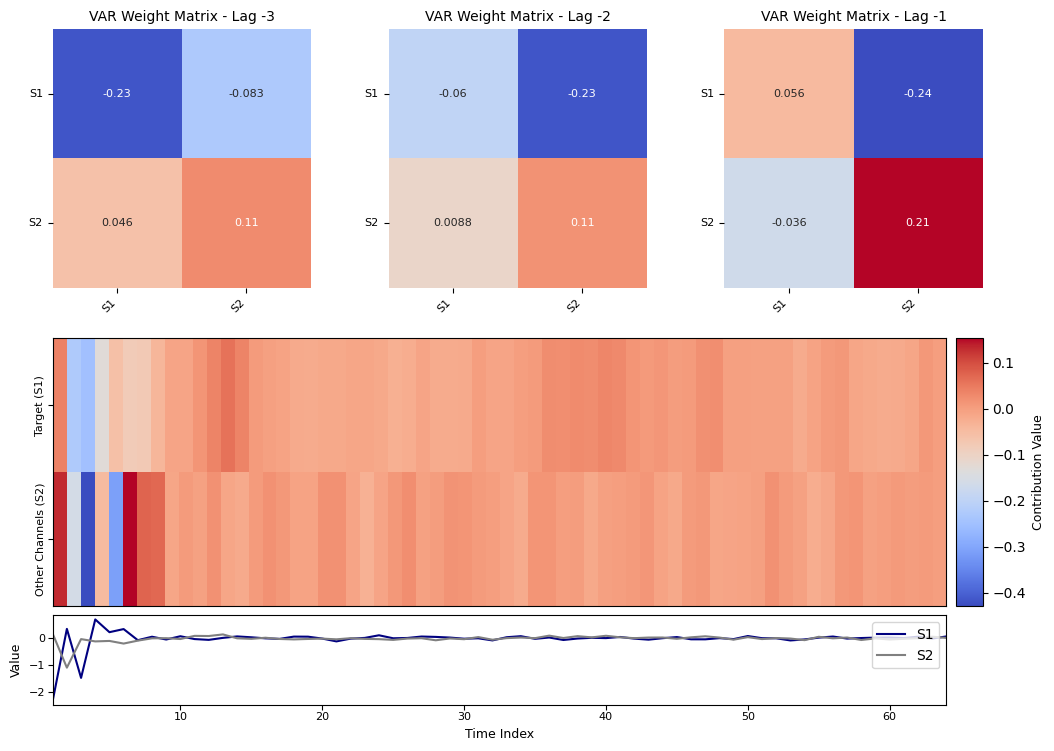

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable 

def plot_combined_figures(var_weight, data, target_idx=0, L=4):
    weights = np.array(var_weight[::-1])
    L_orig, dim, _ = weights.shape
    assert L == L_orig, f"VAR lag order mismatch"

    fig = plt.figure(figsize=(12, 9), constrained_layout=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.2, 1.5], hspace=0.1)

    top_gs = gridspec.GridSpecFromSubplotSpec(1, L, subplot_spec=gs[0], wspace=0.3)
    axes_top = [fig.add_subplot(top_gs[i]) for i in range(L)]
    
    vmin, vmax = np.min(weights), np.max(weights)
    for i, ax in enumerate(axes_top):
        sns.heatmap(weights[i], ax=ax, annot=True, cmap='coolwarm', 
                   vmin=vmin, vmax=vmax, cbar=False, 
                   #cbar_kws={'shrink':0.6, 'location': 'top'},
                   square=True, annot_kws={"size":8})
        ax.set_title(f'VAR Weight Matrix - Lag -{L-i}', fontsize=10)
        ax.set_xticklabels([f'S{j+1}' for j in range(dim)], rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels([f'S{j+1}' for j in range(dim)], rotation=0, fontsize=8)

    L_data, C = data.shape
    contr = np.zeros((C, L_data))
    for t in range(L_data):
        if t+1 >= L_data: continue
        for k in range(1, L+1):
            lagged_time = t + 1 - k
            if lagged_time < 0: continue
            for j in range(C):
                contr[j, t] += var_weight[k-1][target_idx, j] * data[lagged_time, j]

    bottom_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], 
                                                height_ratios=[3,1], hspace=0.05)
    ax_heat = fig.add_subplot(bottom_gs[0])
    ax_line = fig.add_subplot(bottom_gs[1], sharex=ax_heat)

    im = ax_heat.imshow(-contr, aspect='auto', origin='lower',
                       cmap='coolwarm', extent=[1, L_data, 0-0.5, 2-0.5])

    divider = make_axes_locatable(ax_heat)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Contribution Value", fontsize=9)

    ax_heat.set_yticks([0, 1])
    ax_heat.set_yticklabels(["Other Channels (S2)", f"Target (S1)"], fontsize=9, rotation=90, verticalalignment='center')
    ax_heat.tick_params(axis='x', which='both', length=0)
    plt.setp(ax_heat.get_xticklabels(), visible=False)

    time_axis = np.arange(1, L_data + 1)
    
    heat_pos = ax_heat.get_position()
    line_pos = ax_line.get_position()
    ax_line.set_position([heat_pos.x0, line_pos.y0, heat_pos.width*0.961, line_pos.height])
    
    ax_line.plot(time_axis, data[:, target_idx], color='navy', linewidth=1.5, label='S1')
    ax_line.plot(time_axis, data[:, target_idx+1], color='grey', linewidth=1.5, label='S2')
    
    ax_line.set_xlabel("Time Index", fontsize=9)
    ax_line.set_ylabel("Value", fontsize=9)
    ax_line.legend(loc="upper right")

    for ax in [ax_heat, ax_line]:
        ax.tick_params(axis='both', labelsize=8, pad=2)

    ax_heat.set_xlim(1, L_data)
    ax_line.set_xlim(1, L_data)

    plt.savefig("Combined_Visualization_Obs.pdf", format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

#var_weight = ...
data_sample = d[0][0].detach().cpu().numpy()
plot_combined_figures(var_weight, d[0][0].detach().cpu().numpy(), target_idx=0, L=len(var_weight))

In [11]:
from tqdm.auto import tqdm

def compute_samovar_var_weights(Q, V, max_layers):
    """
    Compute VAR weights for all (t,j) pairs using dynamic programming.
    
    Args:
        Q: (M, B, L, H, D) Query tensor for each layer
        V: (M, B, L, H, D) Value tensor for each layer
        max_layers: Number of attention layers (M)
    
    Returns:
        var_weights: (B, L, L, H, D, D) VAR weight matrices
    """
    device = Q.device
    B, L, H, D = Q.shape[1], Q.shape[2], Q.shape[3], Q.shape[4]
    
    # Initialize B tensor with identity matrices
    B_prev = torch.zeros(B, L, L, H, D, D, device=device)
    idx = torch.arange(L)
    B_prev[:, idx, idx] = torch.eye(D, device=device)[None, None, None, :, :]
    
    # Create causal mask
    mask = torch.tril(torch.ones(L, L, device=device))  # (L, L)
    
    for layer in range(max_layers):
        # Get current layer's Q and V
        Q_l = Q[layer]  # (B, L, H, D)
        V_l = V[layer]  # (B, L, H, D)
        
        # Compute attention scores for current layer
        A = torch.einsum('bthd,bihd->btih', Q_l, V_l)  # (B, L, L, H)
        
        # Apply causal masking
        A_masked = A * mask[None, :, :, None]  # (B, L, L, H)
        
        # Update B using dynamic programming
        B_next = torch.einsum('btih,bijhde->btjhde', 
                             A_masked, B_prev)  # (B, L, L, H, D, D)
        
        B_prev = B_next
    
    return B_prev

def get_var_weight_matrix(var_weights, t, j):
    """
    Extract VAR weight matrix for specific time indices.
    
    Args:
        var_weights: (B, L, L, H, D, D) VAR weights
        t: Target time index (scalar)
        j: Source time index (scalar)
    
    Returns:
        weight_matrix: (B, H, D, D) VAR weight matrix
    """
    return var_weights[:, t, j]  # (B, H, D, D)

# Compute all VAR weights
var_weights = compute_samovar_var_weights(Q=q, V=v, max_layers=q.shape[0])
t_idx = -1
weight_matrix = var_weights[:, t_idx] # C L h d d
S = model_arforecast.transformer.generate_S(get_inverse=False).permute(0, 2, 1) # h d d
weight_matrix = torch.einsum('hdk,clhke->clhde', S, weight_matrix)
weight_matrix[:, -1] = weight_matrix[:, -1] + torch.eye(weight_matrix.shape[-1]).to(weight_matrix.device)
head_index = None
factor_index = 0
weight_matrix = weight_matrix[factor_index] if factor_index is not None else weight_matrix.mean(dim=0)
weight_matrix = weight_matrix[:, head_index] if head_index is not None else weight_matrix.mean(dim=1)
observation = k[0][factor_index] if factor_index is not None else k[0].mean(dim=0)
observation = observation[:, head_index] if head_index is not None else observation.mean(dim=1)
_, C, L, h, dim = k.shape
projection = model_arforecast.tokenizer.tokenizer_output.weight   # s D
projection = projection.reshape(-1, h, dim)[:, head_index] if head_index is not None else projection.reshape(-1, h, dim).mean(dim=1)          # s d
weight_matrix = torch.einsum('lde,se->lds', weight_matrix, projection)
weight_matrix = torch.einsum('lek,se->lsk', weight_matrix, projection)
observation = torch.einsum('le,se->ls', observation, projection)

QKT = torch.einsum('mblhd,mbihd->mbhli', q, k)
QKT = QKT.mean(dim=0)
QKT = QKT[factor_index] if factor_index is not None else QKT.mean(dim=0)  # h L L
QKT = QKT[head_index] if head_index is not None else QKT.mean(dim=0)      # L L
QKT = (QKT - QKT.mean()) / QKT.std()
QKT = torch.tril(QKT)

L, hrz, _ = weight_matrix.shape
weight_matrix_flatten = weight_matrix.reshape(L//2, 2, hrz, hrz).permute(1, 0, 2, 3).reshape(2, hrz * L//2, hrz).permute(1, 0, 2)   # L_real 2 hrz
weight_matrix_flatten = (weight_matrix_flatten - weight_matrix_flatten.mean()) / weight_matrix_flatten.std()
observation_flatten = observation.reshape(L//2, 2, hrz).permute(1, 0, 2).reshape(2, hrz * L//2).T
observation_flatten = (observation_flatten - observation_flatten.mean()) / observation_flatten.std()

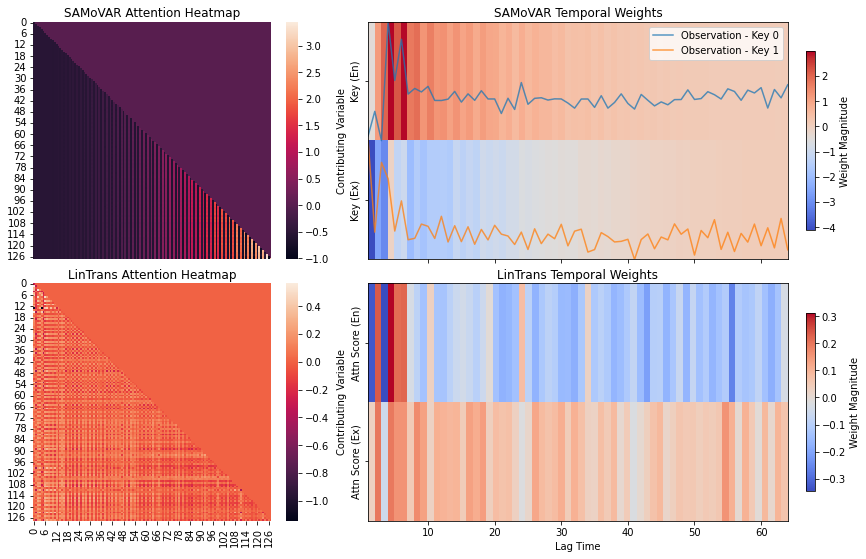

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from tqdm import tqdm

def visualize_optimized_var(weights, observations, axes, height_ratio=1):
    L, C, dim = weights.shape
    assert len(axes) == dim, "Number of axes must match the dimension of weights"

    for i in range(dim):
        ax = axes[i]
        cumulative_weights = weights[:, :, i].T 
        time = np.arange(1, L + 1)
        im = ax.imshow(
            cumulative_weights, 
            aspect="auto", 
            cmap="coolwarm", 
            extent=[1, L, C - 0.5, -0.5],
            origin='lower'
        )
        ax.set_ylabel("Contributing Variable")
        ax.set_yticks(range(C))
        ax.set_yticklabels(['Key (En)', 'Key (Ex)'], rotation=90, verticalalignment='center')
        ax.set_xticklabels([])

        cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.04)
        cbar.set_label("Weight Magnitude")

        for j in range(C):
            current_observations = observations[:, j]
            current_obs_min = current_observations.min()
            current_obs_max = current_observations.max()
            if current_obs_max != current_obs_min:
                current_observations = (current_observations - current_obs_min) / (current_obs_max - current_obs_min)
            else:
                current_observations = np.zeros_like(current_observations)
            current_observations = current_observations - 0.5
            ax.plot(
                time, 
                current_observations + j, 
                linewidth=1.5,
                alpha=0.75,
                label=f"Observation - Key {j}"
            )
        if i == 0:
            ax.legend()

    axes[-1].set_title("SAMoVAR Temporal Weights", pad=5)

weights = weight_matrix_flatten.detach().cpu().numpy()
L, C, dim = weights.shape
height_ratio_samovar = 5

fig = plt.figure(figsize=(14, 9), dpi=72)
gs = gridspec.GridSpec(2, 2, 
                       width_ratios=[1, 1.5], 
                       height_ratios=[1, 1],
                       hspace=0.1, wspace=0.1)

# SAMoVAR Attention Heatmap
ax_samovar_attn = fig.add_subplot(gs[0, 0])
sns.heatmap(QKT.detach().cpu().numpy(), 
           ax=ax_samovar_attn,
           xticklabels=False)
ax_samovar_attn.set_title("SAMoVAR Attention Heatmap", pad=5)

# SAMoVAR Temporal Weights
samovar_temporal_gs = gridspec.GridSpecFromSubplotSpec(
    dim, 1, 
    subplot_spec=gs[0, 1], 
    hspace=0.05
)
samovar_temporal_axes = [fig.add_subplot(samovar_temporal_gs[i]) for i in range(dim)]
visualize_optimized_var(weights, observation_flatten.detach().cpu().numpy(), samovar_temporal_axes)

ax_arattn_attn = fig.add_subplot(gs[1, 0])
model_arattn = runs['ARAttn']['model']
attn_input, _ = model_arattn.get_attn_input(x_input)
weight_matrices = torch.stack([model_arattn.transformer.attn[li].generate_weights(attn_input[li]) for li in range(len(attn_input))])
weight_matrices = weight_matrices.mean(dim=0)[0].mean(dim=0)
sns.heatmap(weight_matrices.detach().cpu().numpy(), 
           ax=ax_arattn_attn)
ax_arattn_attn.set_title("LinTrans Attention Heatmap", pad=5)

ax_arattn_temporal = fig.add_subplot(gs[1, 1])
length = weight_matrices.shape[0]
weight_matrices_last = weight_matrices[-1].reshape(length//2, 2)
im = ax_arattn_temporal.imshow(
            weight_matrices_last.detach().cpu().numpy().T, 
            aspect="auto", 
            cmap="coolwarm", 
            extent=[1, L, C - 0.5, -0.5],
            origin='lower'
        )
cbar = plt.colorbar(im, ax=ax_arattn_temporal, fraction=0.02, pad=0.04)
cbar.set_label("Weight Magnitude")
ax_arattn_temporal.set_ylabel("Contributing Variable")
ax_arattn_temporal.set_yticks(range(2))
ax_arattn_temporal.set_yticklabels(['Attn Score (En)', 'Attn Score (Ex)'], rotation=90, verticalalignment='center')
ax_arattn_temporal.set_title("LinTrans Temporal Weights", pad=5)
ax_arattn_temporal.set_xlabel("Lag Time")

plt.grid(False)

plt.savefig("Combined_Visualization_Attn.pdf", format='pdf', bbox_inches='tight', dpi=72)
plt.show()

In [14]:
# outputs = []
# for model_name in runs:
#     print(model_name)
#     runs[model_name]['model'].eval()
#     output, loss = runs[model_name]['forward'](runs[model_name]['model'], (d[0], d[1]))
#     outputs.append(output[0].detach().cpu().numpy())
# ground_truth = torch.cat([d[0], d[1]], dim=1)
# mts_visualize(outputs, 
#               ground_truth[0].detach().cpu().numpy(), 
#               split_step=ar_config.seq_len)
# pass